In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np  # Add this import
from sklearn.metrics import accuracy_score
import torch

In [ ]:
import re

# Text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+', ' ', text)  # Remove URLs
    text = re.sub(r'@\w+', ' ', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'&[a-z]+;', '', text)  # Remove HTML codes
    text = ' '.join(text.split())  # Remove extra whitespaces
    return text

# Load the dataset
file_dir = "/content/drive/MyDrive/Sentiment Analysis/Tweets.csv"  # Adjust the path if needed
df = pd.read_csv(file_dir)

# Select necessary columns and encode sentiment labels
df = df[['airline_sentiment', 'text']]
df['label'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})  # Encode labels

# Clean the text
df['cleaned_text'] = df['text'].apply(clean_text)

# Remove duplicate entries based on the cleaned text
df = df.drop_duplicates(subset='cleaned_text', keep='first').reset_index(drop=True)

In [ ]:
# Print the first few lines of the cleaned text
print(df[['text', 'cleaned_text']].head(5))

                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                        cleaned_text  
0                                          What said  
1  plus youve added commercials to the experience...  
2  I didnt today Must mean I need to take another...  
3  its really aggressive to blast obnoxious enter...  
4            and its a really big bad thing about it  


<Axes: xlabel='airline_sentiment', ylabel='None'>

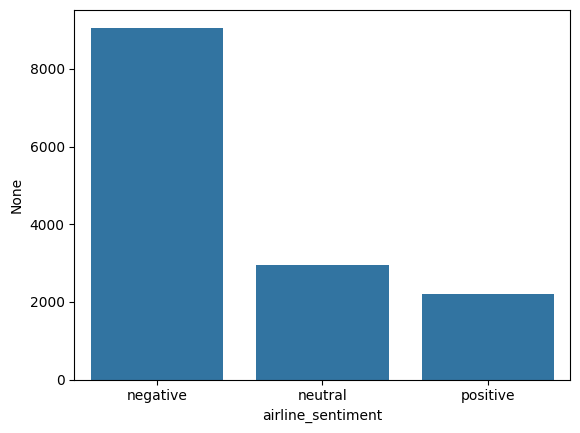

In [ ]:
import seaborn as sns
grouped = df.groupby('airline_sentiment').size()
sns.barplot(x = grouped.index, y = grouped)

<Axes: xlabel='airline_sentiment', ylabel='None'>

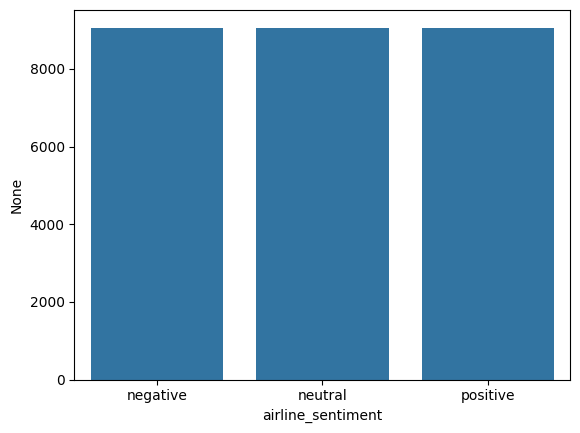

In [57]:
#THIS DOESNT WORK BECAUSE IT SIMPLY DUPLICATES THE DATA
# sentiment_counts = df['airline_sentiment'].value_counts()
# max_count = sentiment_counts.max()
# to_duplicate = {sentiment: max_count - count for sentiment, count in sentiment_counts.items() if count < max_count}

# # Duplicate the rows
# for sentiment, additional in to_duplicate.items():
#     to_duplicate_df = df[df['airline_sentiment'] == sentiment].sample(additional, replace=True)
#     df = pd.concat([df, to_duplicate_df], ignore_index=True)
#   # Visualize the balanced dataset
# grouped = df.groupby('airline_sentiment').size()
# sns.barplot(x=grouped.index, y=grouped)

In [66]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.0 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


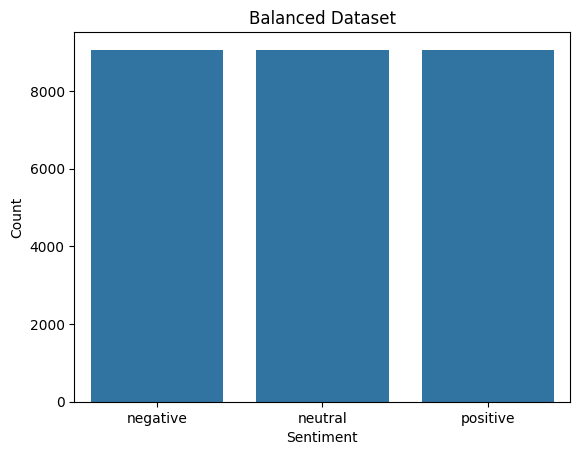

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nlpaug.augmenter.word import SynonymAug

# Initialize a synonym augmenter
aug = SynonymAug(aug_src='wordnet')

# Calculate the counts for each sentiment
sentiment_counts = df['airline_sentiment'].value_counts()
max_count = sentiment_counts.max()
to_augment = {sentiment: max_count - count for sentiment, count in sentiment_counts.items() if count < max_count}

# Augment and balance the dataset
augmented_data = []
for sentiment, additional in to_augment.items():
    # Filter rows for the specific sentiment
    sentiment_df = df[df['airline_sentiment'] == sentiment]

    for _ in range(additional):
        # Sample a random row and augment the text
        random_row = sentiment_df.sample(1).iloc[0]
        original_text = random_row['text']
        augmented_text = aug.augment(original_text)

        # Append the augmented row to the list
        augmented_data.append({
            'text': augmented_text,
            'airline_sentiment': sentiment
        })

# Convert the augmented data to a DataFrame and combine with the original
augmented_df = pd.DataFrame(augmented_data)
df = pd.concat([df, augmented_df], ignore_index=True)

# Visualize the balanced dataset
grouped = df.groupby('airline_sentiment').size()
sns.barplot(x=grouped.index, y=grouped)
plt.title('Balanced Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [68]:
# Check for missing values
print(df.isnull().sum())

airline_sentiment    0
text                 0
label                0
cleaned_text         0
dtype: int64


In [69]:
# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

In [ ]:
def tokenize_function(examples):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs['labels'] = examples['label']  # Include labels
    return tokenized_inputs

In [70]:
# Convert dataframes to Huggingface's Dataset format and tokenize
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])

Map:   0%|          | 0/17130 [00:00<?, ? examples/s]

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

Map:   0%|          | 0/8158 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [71]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [72]:
# Start training
trainer.train()

# Evaluate the model on the test set
results = trainer.evaluate(test_dataset)
print(f"Test set evaluation results: {results}")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.001800,0.175457,0.973739,0.973754,0.973739,0.973679
2,0.000100,0.171578,0.977941,0.977979,0.977941,0.977900
3,0.000000,0.201605,0.976366,0.976534,0.976366,0.976314
4,0.000000,0.188046,0.979517,0.979562,0.979517,0.979480


Test set evaluation results: {'eval_loss': 0.3866490125656128, 'eval_accuracy': 0.9523167443000735, 'eval_precision': 0.9535510112334815, 'eval_recall': 0.9523167443000735, 'eval_f1': 0.9519975404788064, 'eval_runtime': 15.8471, 'eval_samples_per_second': 514.795, 'eval_steps_per_second': 64.365, 'epoch': 4.0}


In [73]:
# Ensure the model is in evaluation mode
model.eval()

# Set the device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the device (GPU/CPU)
def evaluate_model(test_dataset):
    all_preds = []
    all_labels = []

    # Use DataLoader for efficiency
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

    for batch in test_loader:
        inputs = {key: value.to(device) for key, value in batch.items() if key in ['input_ids', 'attention_mask']}
        labels = batch['labels'].to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted class (logits)
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=-1)

        # Append prediction and true label for later accuracy calculation
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy using sklearn
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


In [74]:
test_accuracy = evaluate_model(test_dataset)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

Test set accuracy: 95.23%


In [77]:
def find_misclassified_examples(model, tokenizer, test_dataset, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the appropriate device

    misclassified_examples = []

    # Create a DataLoader for the test dataset
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

    with torch.no_grad():
        for batch in test_loader:
            # Move inputs and labels to the device
            inputs = {key: value.to(device) for key, value in batch.items() if key in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)

            # Get model outputs
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Find misclassified examples
            misclassified_mask = predictions != labels
            misclassified_indices = misclassified_mask.nonzero(as_tuple=True)[0]

            for idx in misclassified_indices:
                # Get the original text (we need to map back to the original dataset)
                # Since the DataLoader shuffles data by default, make sure to set shuffle=False
                # Also, the Dataset object should have the 'text' field
                text = test_dataset[int(idx)]['text']
                true_label = labels[idx].cpu().item()
                predicted_label = predictions[idx].cpu().item()

                misclassified_examples.append({
                    'text': text,
                    'true_label': true_label,
                    'predicted_label': predicted_label
                })

    # Print misclassified examples
    print("Misclassified Examples:")
    for example in misclassified_examples:
        print(f"Text: {example['text']}")
        print(f"True Label: {example['true_label']}")
        print(f"Predicted Label: {example['predicted_label']}")
        print("-" * 50)

    return misclassified_examples


In [78]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
misclassified_examples = find_misclassified_examples(model, tokenizer, test_dataset, device)

Misclassified Examples:
Text: @USAirways Thx to gate agt John Pascucci for finding us a flight from CLT to PVD after our original one was Cancelled Flightled http://t.co/YiwLhQhZgp
True Label: 0
Predicted Label: 2
--------------------------------------------------
Text: @united flight attendant regains karma by giving big sweaty dad cold water. Guy was running &amp; carrying his daughter.  Last one onboard.
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: @AmericanAir flight 353
True Label: 1
Predicted Label: 2
--------------------------------------------------
Text: @JetBlue I know you guys are super busy but is flight 1222 an a320 or e190?
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: @JetBlue I know you guys are super busy but is flight 1222 an a320 or e190?
True Label: 0
Predicted Label: 1
--------------------------------------------------
Text: @AmericanAir Thanks. Having issues checking in for fl

In [79]:
print(len(misclassified_examples))

389
